In [1]:
import numpy as np
import cmocean
import xarray
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.integrate import cumtrapz

In [2]:
pcldata = xarray.open_dataset("24May10m-test2.nc") ## the parcel netcdf
simdata = xarray.open_dataset("ElReno10m-a.05100.000000.nc") ## a NetCDF I use to contour the surface

In [3]:
## parcel position arrays - convert from meters to km
xpos = pcldata.xpos.to_masked_array().swapaxes(0,1) / 1000.0
ypos = pcldata.ypos.to_masked_array().swapaxes(0,1) / 1000.0
zpos = pcldata.zpos.to_masked_array().swapaxes(0,1) / 1000.0

## base state and perturbation scalars
rhopert = pcldata.rhopert.to_masked_array().swapaxes(0, 1)
rhobar = pcldata.rhobar.to_masked_array().swapaxes(0,1)
thrhopert = pcldata.thrhopert.to_masked_array().swapaxes(0,1)
thrhobar = pcldata.thrhobar.to_masked_array().swapaxes(0,1)
prespert = pcldata.prespert.to_masked_array().swapaxes(0, 1)
presbar = pcldata.presbar.to_masked_array().swapaxes(0,1)

## parcel velocity arrays
u = pcldata.u.to_masked_array().swapaxes(0,1)
v = pcldata.v.to_masked_array().swapaxes(0,1)
w = pcldata.w.to_masked_array().swapaxes(0,1)

## parcel momentum budget components
upgrad = pcldata.upgrad.to_masked_array().swapaxes(0,1)
vpgrad = pcldata.vpgrad.to_masked_array().swapaxes(0,1)
wpgrad = pcldata.wpgrad.to_masked_array().swapaxes(0,1)
wbuoy = pcldata.wbuoy.to_masked_array().swapaxes(0,1)
udiff = pcldata.udiff.to_masked_array().swapaxes(0,1)
vdiff = pcldata.vdiff.to_masked_array().swapaxes(0,1)
wdiff = pcldata.wdiff.to_masked_array().swapaxes(0,1)
uturb = pcldata.uturb.to_masked_array().swapaxes(0,1)
vturb = pcldata.vturb.to_masked_array().swapaxes(0,1)
wturb = pcldata.wturb.to_masked_array().swapaxes(0,1)

## Parcel vorticity arrays
xvort = pcldata.xvort.to_masked_array().swapaxes(0,1)
yvort = pcldata.yvort.to_masked_array().swapaxes(0,1)
zvort = pcldata.zvort.to_masked_array().swapaxes(0,1)

## Parcel vorticity budget components
xtilt = pcldata.xvorttilt.to_masked_array().swapaxes(0,1)
ytilt = pcldata.yvorttilt.to_masked_array().swapaxes(0,1)
ztilt = pcldata.zvorttilt.to_masked_array().swapaxes(0,1)
xstretch = pcldata.xvortstretch.to_masked_array().swapaxes(0,1)
ystretch = pcldata.yvortstretch.to_masked_array().swapaxes(0,1)
zstretch = pcldata.zvortstretch.to_masked_array().swapaxes(0,1)
xdiff = pcldata.xvortdiff.to_masked_array().swapaxes(0,1)
ydiff = pcldata.yvortdiff.to_masked_array().swapaxes(0,1)
zdiff = pcldata.zvortdiff.to_masked_array().swapaxes(0,1)
xturb = pcldata.xvortturb.to_masked_array().swapaxes(0,1)
yturb = pcldata.yvortturb.to_masked_array().swapaxes(0,1)
zturb = pcldata.zvortturb.to_masked_array().swapaxes(0,1)
xbaro = pcldata.xvortbaro.to_masked_array().swapaxes(0,1)
ybaro = pcldata.yvortbaro.to_masked_array().swapaxes(0,1)
xsol = pcldata.xvortsolenoid.to_masked_array().swapaxes(0,1)
ysol = pcldata.yvortsolenoid.to_masked_array().swapaxes(0,1)
zsol = pcldata.zvortsolenoid.to_masked_array().swapaxes(0,1)

## compute streamwise vorticity from the arrays
streamvort = (u*xvort + v*yvort * w*zvort)/ np.sqrt(u**2 + v**2 + w**2)

## the surface I contour
thrhopert_sfc = simdata.snapshot_thrho_sfc.values[ 0, :, :]
print(thrhopert_sfc.shape, thrhopert_sfc.min(), thrhopert_sfc.max())
xh = simdata.xh.to_masked_array()
yh = simdata.yh.to_masked_array()

xh, yh = np.meshgrid(xh, yh)
print(xh.shape, yh.shape)

(2078, 2078) -9.130859 2.34906
(2078, 2078) (2078, 2078)


In [4]:
## This handles some filtering - in this case, exclude any parcels below the lowest scalar grid
## level
lines = np.where( np.any(zpos < simdata.xh.values[0], axis=0) == False )[0]

/home/khalbert/miniconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
def create_parcel_plot(pcl_field=None, surface_field=None, surface_field_args={}, pcl_cmap=cmocean.cm.deep, pltxlim=(-12000, 3000), \
                       pltylim=(-4000, 13000), pltzlim=(0, 1000), pltnorm=(0, 1), stride=5, dpi=100, \
                       output_name="parcels.png", cbar_label=""):
    """Create the parcel overview plot with the plan view at the center, 
       and the vertical views as side panels."""
    
    norm = plt.Normalize(pltnorm[0], pltnorm[1])
    pltcmap = pcl_cmap
    
    fig = plt.figure(figsize=(11,10), dpi=dpi)
    gs = gridspec.GridSpec(10, 10)
    ax1 = plt.subplot(gs[0:2, :-2])
    ax2 = plt.subplot(gs[2:, :-2])
    ax3 = plt.subplot(gs[2:, -2:])

    ax1.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    ax1.set_ylabel("Height (km)")
    ax3.set_xlabel("Height (km)")
    ax2.set_xlabel("X Coordinate (km)")
    ax2.set_ylabel("Y Coordinate (km)")
    ax1.set_facecolor('#afafaf')
    ax2.set_facecolor('#afafaf')
    ax3.set_facecolor('#afafaf')

    axs = [ax1, ax2, ax3]

    ## main panel
    axs[1].contourf(xh, yh, surface_field, zorder=-100000, cmap=surface_field_args["cmap"], \
                        levels=surface_field_args["levels"], extend="both")
    axs[1].set_xlim(pltxlim[0], pltxlim[1])
    axs[1].set_ylim(pltylim[0], pltylim[1])

    ## top panel
    axs[0].set_xlim(pltxlim[0], pltxlim[1])
    axs[0].set_ylim(pltzlim[0], pltzlim[1])

    ##right panel
    axs[2].set_xlim(pltzlim[0], pltzlim[1])
    axs[2].set_ylim(pltylim[0], pltylim[1])

    ## Create a continuous norm to map from data points to colors
    ## for the trajectory trace, i.e. the min/max value of the line color

    ## Loop over the filtered lines
    for line in lines[::stride]:
        x = np.array(xpos[:-1, line])
        y = np.array(ypos[:-1, line])
        z = np.array(zpos[:-1, line])
        zend = -2

        # Create a set of line segments so that we can color them individually
        # This creates the points as a N x 1 x 2 array so that we can stack points
        # together easily to get the segments. The segments array for line collection
        # needs to be (numlines) x (points per line) x 2 (for x and y)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:zend], points[1:zend+1]], axis=1)

        lc = LineCollection(segments, cmap=pltcmap, norm=norm)
        # Set the values used for colormapping
        lc.set_array(pcl_field[:-1, line])
        lc.set_linewidth(2)
        pline1 = axs[1].add_collection(lc)    

        points = np.array([x, z]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:zend], points[1:zend+1]], axis=1)

        lc = LineCollection(segments, cmap=pltcmap, norm=norm)
        # Set the values used for colormapping
        lc.set_array(pcl_field[:-1, line])
        lc.set_linewidth(2)
        pline2 = axs[0].add_collection(lc)


        points = np.array([z, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:zend], points[1:zend+1]], axis=1)

        lc = LineCollection(segments, cmap=pltcmap, norm=norm)
        # Set the values used for colormapping
        lc.set_array(pcl_field[:-1, line])
        lc.set_linewidth(2)
        pline3 = axs[2].add_collection(lc)

    cbaxes = inset_axes(ax2, width="3%", height="98%", loc="upper right") 
    cb = plt.colorbar(pline3, cax=cbaxes, orientation='vertical', ticks=np.linspace(pltnorm[0], pltnorm[1], 3))
    cb.ax.yaxis.set_ticks_position('left')
    cb.ax.yaxis.set_label_position('right')
    
    cb.set_label(cbar_label, labelpad=10)

    plt.tight_layout()
    plt.savefig(output_name, bbox_inches="tight")
    plt.show()
    plt.close()

/home/khalbert/miniconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


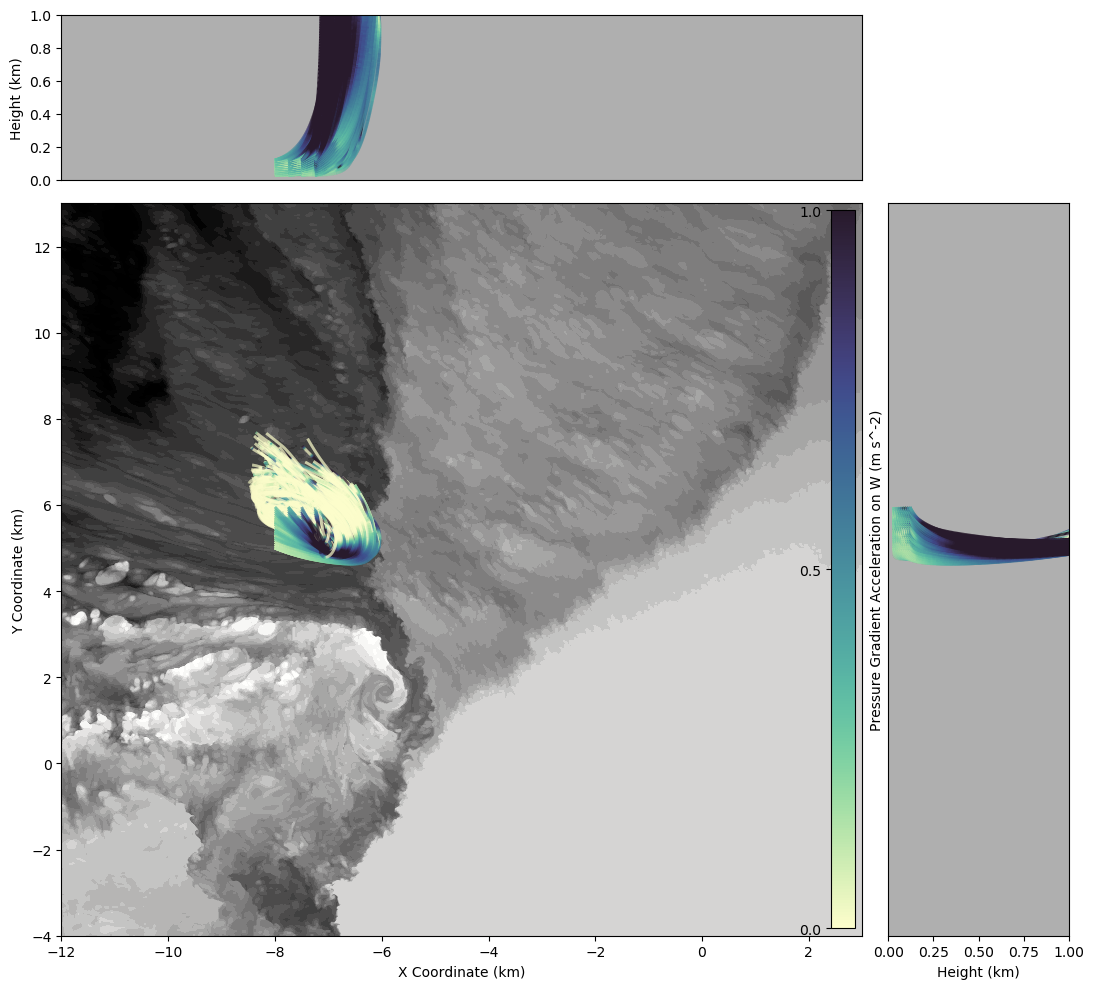

In [17]:
%matplotlib inline
sfc_args = {"levels": np.arange(-8,2,.5),\
            "cmap": cmocean.cm.gray}

## the "Stride" argument just filters how many parcels are actually displayed.
## A stride of 5 means every 5th parcel. Increasing the stride drastically improves
## perfomance by decreasing the density of parcels plotted. 
create_parcel_plot(pcl_field=wpgrad, surface_field=thrhopert_sfc, surface_field_args=sfc_args, \
                   pcl_cmap=cmocean.cm.deep, pltxlim=(-12, 3), pltylim=(-4, 13), pltzlim=(0, 1), \
                   pltnorm=(0, 1), stride=5, dpi=100, output_name="parcels_test_10m.png", \
                   cbar_label="Pressure Gradient Acceleration on W (m s^-2)")

In [ ]:
## This code integrates the vorticity tendencies into full budgets
line = lines[10]
times = np.arange(0, xpos.shape[0]-1)
t = times
print(zpos[0, line])
try:
    zend = np.where(zpos[:, line] > 3000.)[0][0]
except: zend = len(times)
#zend = len(times)
#zend = 1750

## From Alex Schueth
def integrate(var,varint,j,dt):
    return varint[j-1] + dt*(var[j-1, line] + var[j, line])/2.

xi_int         = np.zeros(np.shape(t))
xi_tilt_int    = np.zeros(np.shape(t))
xi_stretch_int = np.zeros(np.shape(t))
xi_baro_int = np.zeros(np.shape(t))
xi_sgs_int     = np.zeros(np.shape(t))
xi_int_sum   = np.zeros(np.shape(t))

eta_int         = np.zeros(np.shape(t))
eta_tilt_int    = np.zeros(np.shape(t))
eta_stretch_int = np.zeros(np.shape(t))
eta_baro_int = np.zeros(np.shape(t))
eta_sgs_int     = np.zeros(np.shape(t))
eta_int_sum   = np.zeros(np.shape(t))

zeta_int         = np.zeros(np.shape(t))
zeta_tilt_int    = np.zeros(np.shape(t))
zeta_stretch_int = np.zeros(np.shape(t))
zeta_sol_int = np.zeros(np.shape(t))
zeta_sgs_int     = np.zeros(np.shape(t))
zeta_int_sum   = np.zeros(np.shape(t))

xi_int [0]          = 0.5 * (xvort[0, line] + xvort[1, line])
eta_int [0]          = 0.5 * (yvort[0, line] + yvort[1, line])
zeta_int [0]          = 0.5 * (zvort[0, line] + zvort[1, line])


for j in range(1,len(t[:zend])):
    #dt=0.5
    #dt=0.1666667
    dt=0.2
    
    xi_int[j] = xi_int[j-1]+xtilt[j, line]*dt+xstretch[j, line]*dt+xturb[j, line]*dt+xsol[j, line]*dt+xdiff[j, line]*dt+xbaro[j, line]*dt
    eta_int[j] = eta_int[j-1]+ytilt[j, line]*dt+ystretch[j, line]*dt+yturb[j, line]*dt+ysol[j, line]*dt+ydiff[j, line]*dt+ybaro[j, line]*dt
    zeta_int[j] = zeta_int[j-1]+ztilt[j, line]*dt+zstretch[j, line]*dt+zturb[j, line]*dt+zsol[j, line]*dt+zdiff[j, line]*dt



fig = plt.figure(figsize=(11,8.5), dpi=400)
plt.plot(times[:zend], xi_int[:zend], 'b--', label="xi integrated")
plt.plot(times[:zend], xvort[:zend, line], 'b-', label="xi parcel")
plt.plot(times[:zend], eta_int[:zend], 'k--', label="eta integrated")
plt.plot(times[:zend], yvort[:zend, line], 'k-', label="eta parcel")
plt.plot(times[:zend], zeta_int[:zend], 'r--', label="zeta integrated")
plt.plot(times[:zend], zvort[:zend, line], 'r-', label="zeta parcel")
#plt.ylim(-.15,.1)
ax = plt.gca()
ax.set_facecolor('#afafaf')
plt.legend()
plt.savefig("integrated6_30m.png")
plt.show()
plt.close()

fig = plt.figure(figsize=(11,8.5), dpi=400)
plt.axhline(0.0, color='k', linestyle=':')
plt.plot(times[:zend], ztilt[:zend, line], color='k', linestyle='-',label="tilting")
plt.plot(times[:zend], zstretch[:zend, line], color='k', linestyle='--', label="stretching")
plt.plot(times[:zend], zturb[:zend, line], color='#1092a3', linestyle='-', label="turbulence")
plt.plot(times[:zend], zdiff[:zend, line], color='w', linestyle='-', label='ediff')
plt.plot(times[:zend], zsol[:zend, line], color='#b52a2a', linestyle='-', label="solenoidal")
#plt.plot(times[:zend], ybaro[:zend, line], color='r', linestyle='-', label="baroclinic")
#plt.plot(times[:zend], wpgrad[:zend, line],'r')

ax = plt.gca()
#plt.ylim(0,20)
#plt.xlim(0,500)
ax.set_facecolor('#afafaf')
plt.legend()
plt.savefig("buget6_30m.png")
plt.show()
plt.close()